# **Altmetric Regression Reranking**

In this notebook, I will be running experiments in order to evaluate the effectiveness of reranking with my Altmetric Regression model.  I will retrieve 1000 documents using BM25 and then select the documents with the top 100 Altmetric predictions, using the regression model.  It will be tested on the CORD-19 dataset as of 16/07/2020, in accordance with the documents available for Round 5 of TREC-COVID.  The relevance judgement - qrels - used to calculate ndcg scores will be our testing dataset - the relevance judgements made for Round 5 of the challenge.  I will be evaluating the methods on the standard measures used in Round 5 of TREC-COVID.

## **Setup**

### **Pyterrier**

In [ ]:
!pip install --upgrade python-terrier

     |████████████████████████████████| 97 kB 3.0 MB/s 
     |████████████████████████████████| 1.1 MB 27.7 MB/s 
     |████████████████████████████████| 69 kB 6.0 MB/s 
     |████████████████████████████████| 255 kB 75.5 MB/s 
     |████████████████████████████████| 41 kB 198 kB/s 
     |████████████████████████████████| 294 kB 48.6 MB/s 
     |████████████████████████████████| 596 kB 50.9 MB/s 
     |████████████████████████████████| 6.4 MB 51.1 MB/s 
     |████████████████████████████████| 1.2 MB 50.1 MB/s 
     |████████████████████████████████| 72 kB 1.2 MB/s 
     |████████████████████████████████| 126 kB 55.7 MB/s 
     |████████████████████████████████| 291 kB 61.8 MB/s 
     |████████████████████████████████| 59 kB 3.5 MB/s 
     |████████████████████████████████| 45 kB 2.3 MB/s 
  Created wheel for python-terrier: filename=python_terrier-0.8.0-py3-none-any.whl size=103883 sha256=4ca97debec8a62b86da2f5cfd4d26fd594230bf927fda775de550cf36ba16fc2
  Stored in directory: /root/.cac

In [ ]:
import pyterrier as pt
if not pt.started():
  pt.init()

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.8.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



In [ ]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/CORD-19%20Datasets/round5_index_docs.zip?raw=true
!unzip -u "/content/round5_index_docs.zip?raw=true" -d "/content/index_docs"

--2022-02-15 16:59:14--  https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/CORD-19%20Datasets/round5_index_docs.zip?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/CORD-19%20Datasets/round5_index_docs.zip [following]
--2022-02-15 16:59:14--  https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/CORD-19%20Datasets/round5_index_docs.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/CORD-19%20Datasets/round5_index_docs.zip [following]
--2022-02-15 16:59:14--  https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/CORD-19%20Datasets/round5_index_docs.zip
Resolving raw.git

In [ ]:
index = pt.IndexFactory.of("/content/index_docs/content/terrier_cord19/data.properties")

In [ ]:
cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')
topics = cord19.get_topics('title')

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [8.46MB/s]
/usr/local/lib/python3.7/dist-packages/pyterrier/datasets.py:433: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronaBERT_Embeddings/coronaBERT_doc_embeddings.pickle?raw=true

with open('/content/coronaBERT_doc_embeddings.pickle?raw=true', 'rb') as f:
  doc_embeddings = pickle.load(f)

In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronaBERT%20Embeddings/coronaBERT_query_embeddings.pickle?raw=true
with open('/content/coronaBERT_query_embeddings.pickle?raw=true', 'rb') as f:
  query_embeddings = pickle.load(f)

In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Models/altmetric_regression_model.pickle?raw=true

--2022-02-15 15:06:58--  https://github.com/DavidONeill75101/level-4-project/blob/master/Models/altmetric_regression_model.pickle?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/DavidONeill75101/level-4-project/raw/master/Models/altmetric_regression_model.pickle [following]
--2022-02-15 15:06:58--  https://github.com/DavidONeill75101/level-4-project/raw/master/Models/altmetric_regression_model.pickle
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Models/altmetric_regression_model.pickle [following]
--2022-02-15 15:06:58--  https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Models/altmetric_regression_model.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com

In [ ]:
model = pickle.load(open('/content/altmetric_regression_model.pickle?raw=true', 'rb'))
model

GradientBoostingRegressor(verbose=True)

### **TREC Datasets**

In [ ]:
!wget https://ir.nist.gov/covidSubmit/data/qrels-covid_d4_j0.5-4.txt
!wget https://ir.nist.gov/covidSubmit/data/changedIds-Jul16.csv
!wget https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j4.5-5.txt

--2022-02-15 15:07:37--  https://ir.nist.gov/covidSubmit/data/qrels-covid_d4_j0.5-4.txt
Resolving ir.nist.gov (ir.nist.gov)... 129.6.13.19, 2610:20:6005:13::19
Connecting to ir.nist.gov (ir.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 763591 (746K) [text/plain]
Saving to: ‘qrels-covid_d4_j0.5-4.txt’

qrels-covid_d4_j0.5 100%[===================>] 745.69K  1.15MB/s    in 0.6s    

2022-02-15 15:07:38 (1.15 MB/s) - ‘qrels-covid_d4_j0.5-4.txt’ saved [763591/763591]

--2022-02-15 15:07:38--  https://ir.nist.gov/covidSubmit/data/changedIds-Jul16.csv
Resolving ir.nist.gov (ir.nist.gov)... 129.6.13.19, 2610:20:6005:13::19
Connecting to ir.nist.gov (ir.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34087 (33K) [text/csv]
Saving to: ‘changedIds-Jul16.csv’

changedIds-Jul16.cs 100%[===================>]  33.29K  --.-KB/s    in 0.09s   

2022-02-15 15:07:39 (373 KB/s) - ‘changedIds-Jul16.csv’ saved

In [ ]:
import csv

cord_remapping = {}
with open('changedIds-Jul16.csv') as f:
  reader = csv.DictReader(f)
  for row in reader:
    cord_remapping[row['cord_uid_0619']] = row['cord_uid_0716']
len(cord_remapping)

1135

In [ ]:
from collections import Counter,defaultdict

training_judgments_by_topic = defaultdict(dict)
with open('qrels-covid_d4_j0.5-4.txt') as f:
  for line in f:
    topic_id,round_id,doc_id,relevance = line.strip('\n').split()
    topic_id = int(topic_id)
    relevance = int(relevance)
    
    if doc_id in cord_remapping:
      doc_id = cord_remapping[doc_id]

    training_judgments_by_topic[topic_id][doc_id] = relevance


In [ ]:
from collections import defaultdict
qrels = defaultdict(dict)
with open('qrels-covid_d5_j4.5-5.txt') as f:
  for line in f:
    topic_id,iteration,doc_id,judgement = line.strip('\n').split()
    topic_id = int(topic_id)
    judgement = int(judgement)
    qrels[topic_id][doc_id] = judgement

In [ ]:
test_qrels = []
for qid in qrels:
  for docno, judgement in qrels[qid].items():
    test_qrels.append([str(qid), docno, judgement])

test_qrels = pd.DataFrame(test_qrels, columns=['qid', 'docno', 'label'])

In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/CORD-19_Datasets/round5_docs.csv?raw=true

round5_docs = pd.read_csv('/content/round5_docs.csv?raw=true').drop(columns=['Unnamed: 0'])

## **Baseline Retrieval**

In [ ]:
bm25 = pt.BatchRetrieve(index, wmodel='BM25')

In [ ]:
sys_scores = {}

results = []


topic_ids = list(range(1, 51))

for topic_id in tqdm(topic_ids):
  query = topics[topics['qid']==str(topic_id)].iloc[0]['query']
  
  doc_ids_to_exclude = training_judgments_by_topic[topic_id]
  
  result = bm25(query)
   
 
  doc_scores_with_ids = list(zip(result.score,result.docno))
  doc_scores_with_ids = [ (score,doc_id) for score,doc_id in doc_scores_with_ids if not doc_id in doc_ids_to_exclude ]
  doc_scores_with_ids = sorted(doc_scores_with_ids, reverse=True, key=lambda x:x[0])

  sys_scores[topic_id] = doc_scores_with_ids[:1000]

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:269: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  return self.transform(*args, **kwargs)
100%|██████████| 50/50 [00:03<00:00, 15.07it/s]


In [ ]:
scores = []

for qid in sys_scores:
  rank = 0
  for pair in sys_scores[qid]:
    scores.append([str(qid), pair[1], pair[0], rank])
    rank += 1

results = pd.DataFrame(scores, columns=['qid', 'docno', 'score', 'rank'])

## **Altmetric Classifier Reranking**

In [ ]:
def rerank_query_results(query, query_embeddings, doc_embeddings, model, cutoff=100):

  
  query_results = results[results['qid']==str(query)]
  query_embedding = query_embeddings[str(query)]

  docnos = query_results['docno']
  
  doc_embeddings = [np.concatenate([query_embedding, doc_embeddings[docno]]) for docno in docnos]
 
  predictions = model.predict(doc_embeddings)
  
  docno_scores = [[docno, prediction] for docno, prediction in zip(docnos, predictions)]

  docno_scores.sort(key=lambda x:x[1], reverse=True)

  reranked = pd.DataFrame(docno_scores, columns=['docno', 'score']).sort_values(by='score', ascending=False)
  reranked['rank'] = list(range(len(docno_scores)))
  reranked['qid'] = [str(query) for i in range(len(docno_scores))]

  
  
  return reranked[:100]
  

In [ ]:
reranked_dataframes = []
for i in range(1, 51):
  reranked_dataframes.append(rerank_query_results(i, query_embeddings, doc_embeddings, model))

reranked_results = pd.concat(reranked_dataframes)

## **Perform Experiments**

In [ ]:
from pyterrier.measures import *

eval_results = pt.Experiment([
  results, 
  reranked_results
  ],
  topics,
  test_qrels,
  names=["BM25 Baseline", "BM25 with Altmetric Regression Reranking"],
  eval_metrics=["ndcg_cut.20", P@20, Bpref, 'map'],
  baseline=0
)

In [ ]:
eval_results

,name,map,Bpref,P@20,ndcg_cut.20,map +,map -,map p-value,Bpref +,Bpref -,Bpref p-value,P@20 +,P@20 -,P@20 p-value,ndcg_cut.20 +,ndcg_cut.20 -,ndcg_cut.20 p-value
0,BM25 Baseline,0.160014,0.322114,0.490,0.465319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 with Altmetric Regression Reranking,0.023683,0.078814,0.181,0.162582,6.0,44.0,2.134583e-09,1.0,49.0,3.698930e-15,6.0,41.0,1.112417e-10,7.0,42.0,2.451288e-10


In [ ]:
print(eval_results[['name', 'map', 'Bpref', 'P@20', 'ndcg_cut.20', 'map p-value', 'Bpref p-value', 'P@20 p-value', 'ndcg_cut.20 p-value']].to_latex(index=False))

\begin{tabular}{lrrrrrrrr}
\toprule
                                    name &      map &    Bpref &  P@20 &  ndcg\_cut.20 &  map p-value &  Bpref p-value &  P@20 p-value &  ndcg\_cut.20 p-value \\
\midrule
                           BM25 Baseline & 0.160014 & 0.322114 & 0.490 &     0.465319 &          NaN &            NaN &           NaN &                  NaN \\
BM25 with Altmetric Regression Reranking & 0.023683 & 0.078814 & 0.181 &     0.162582 & 2.134583e-09 &   3.698930e-15 &  1.112417e-10 &         2.451288e-10 \\
\bottomrule
\end{tabular}



## **Results**

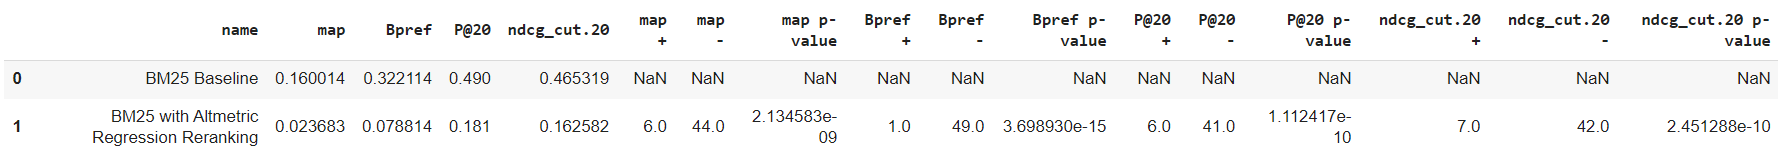